# Text Classification Based on Chinese Dataset THUCNEWs

## DataSetProcess

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import pandas as pd
import re
import jieba
from sklearn.feature_extraction.text import  CountVectorizer, TfidfTransformer
import numpy as np

#文本切分函数，用来对中文文本分词，包括除去数字字母以及停用词，得到一个分词用空格隔开的字符串，便于下面向量化（因为这个CountVouterizer()是针对英文分词的，英文之间直接用空格隔开的）
def cut_word(sent):
    line=re.sub(r'[a-zA-Z0-9]*','',sent)
    wordList=jieba.lcut(line,cut_all=False)
    return ' '.join([word for word in wordList if word not in stopWord and len(word)>1])#文本分词，并且用空格连接起来，便于下面向量化

#也是文本切分函数，只不过这个没有去停用词，CountVouterizer()中可以直接添加停用词表参数，不统计文档中的停用词的数量
def cutword(sent):
    line=re.sub(r'[a-zA-Z0-9]*','',sent)
    wordList=jieba.lcut(line,cut_all=False)
    return ' '.join([word for word in wordList if len(word)>1])
def sentence_to_vector(word_list):
    res=[]
    for i in word_list.split(' '):
        try:
            res.append(np.array(word_dict[i],dtype=np.float32))
        except:
            res.append(np.zeros(300))
    for i in range(30-len(res)):
        res.append(np.zeros(300))
    return res

In [2]:
rawdata = pd.read_csv('./dataset/toutiao/DMSC.csv',low_memory=False)
rawdata = rawdata[rawdata['Movie_Name_CN']=='大圣归来']
rawdata=rawdata[['Star','Comment']]
rawdata['Star'][rawdata['Star']<=2 ]=0
rawdata['Star'][rawdata['Star']>=3 ]=1
print('均匀样本前\n',rawdata.Star.value_counts())
class_num=len(rawdata[rawdata['Star']==0])
data=pd.concat([rawdata[rawdata['Star']==1].sample(class_num),rawdata[rawdata['Star']==0]]).sample(2*class_num)
data.index=range(2*class_num)
print('均匀样本后\n',data.Star.value_counts())

均匀样本前
 1    127547
0      5846
Name: Star, dtype: int64
均匀样本后
 1    5846
0    5846
Name: Star, dtype: int64


/tmp/ipykernel_3406933/2413515671.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rawdata['Star'][rawdata['Star']>=3 ]=1


In [3]:
data.Comment.apply(len).describe()

count    11692.000000
mean        41.156517
std         38.512487
min          2.000000
25%         12.000000
50%         26.000000
75%         57.000000
max        162.000000
Name: Comment, dtype: float64

In [4]:
data # Glove预训练模型

,Star,Comment
0,1,悟空
1,0,呵呵呵呵，我觉得适合小盆友看
2,0,靠水军和各类无德媒体瞎吹，靠各种卑劣手段作假票房数，典型且普遍的国产模式
3,1,良心作品，中国动画片的希望。
4,1,蜜汁哭点TAT
...,...,...
11687,1,特效还行，3D也还行。剧情是硬伤。中国要想真正做出老少皆宜的动画片，必须解决剧情问题。思考...
11688,1,良心作品，中国动漫崛起。
11689,0,本来想给3星，想想人设剧情台词配音还是给了2星。虽说国产有进步，但说惊艳太过，拿到国际上真...
11690,0,这样的片子都能8.4分，豆瓣疯了？ps：汪峰的歌是最大败笔。


### 抽取数据集

In [5]:
select_index=np.array(range(2*class_num))
np.random.shuffle(select_index)
train_label_index=select_index[:int(0.8*2*class_num)]
test_label_index=select_index[int(0.8*2*class_num):int(0.9*2*class_num)]
val_label_index=select_index[int(0.9*2*class_num):]

In [6]:
data['Comment']=data['Comment'].apply(lambda x:x[:30])
data.columns=['labels','texts']
data.head()

,labels,texts
0,1,悟空
1,0,呵呵呵呵，我觉得适合小盆友看
2,0,靠水军和各类无德媒体瞎吹，靠各种卑劣手段作假票房数，典型且
3,1,良心作品，中国动画片的希望。
4,1,蜜汁哭点TAT


In [7]:
#加载停用词，停用词要是列表形式才能使用
import csv
num_class=2
stopWord=list(pd.read_table('./dataset/toutiao/ChineseStopWords.txt',header=None,encoding='utf-8',quoting=csv.QUOTE_NONE)[0].values)

In [8]:
data['word_list']=data.texts.apply(cutword)#将文本分词，并且分词用空格隔开变成文本存才DataFrame中

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.497 seconds.
Prefix dict has been built successfully.


In [9]:
data['length']=data.apply(lambda x:len(x.word_list.split(' ')),axis=1)

In [10]:
filename = './dataset/toutiao/sgns.renmin.word'
def loadWord2Vec(filename):
    vocab = []   #vocab dict
    embd = []    #embedding matrix
    
    #open file
    fr = open(filename, 'r', encoding="utf-8")
    
    #read file line one e.g. 3 300, 3 is num of word, 300 is word dim
    line = fr.readline().strip()
    
    # num of word, line.split(' ')[0], dim, line.split(' ')[1]  
    word_dim = int(line.split(' ')[1])
    print('word_nums:',int(line.split(' ')[0]),'dim',int(line.split(' ')[1]))  
    
    #add word unk to dict
    vocab.append("unk")
    #add unk embd to embd
    embd.append([0]*word_dim)

    for line in fr :
        row = line.strip().split(' ')
        vocab.append(row[0]) #把第一个字/词加入vocab中
        embd.append(row[1:]) #把后面一长串加入embd中
    print("loaded word2vec")
    fr.close()
    word_dict=dict(zip(vocab,embd))
    return word_dict

In [11]:
word_dict=loadWord2Vec(filename)
print('类别统计')
print(data.labels.value_counts())
print('标签编号')
label_dict=dict(zip(data.labels.value_counts().index,range(num_class)))
data.labels=data.labels.replace(label_dict)

word_nums: 355987 dim 300
loaded word2vec
类别统计
1    5846
0    5846
Name: labels, dtype: int64
标签编号


### Pytorch 数据集制作

In [12]:
import torch.utils.data as Data
class MyDataSet(Data.Dataset):

    def __init__(self, data):
        self.x = data['word_list'].values
        self.y = data['labels'].values

    def __getitem__(self, index):
        return np.array(sentence_to_vector(self.x[index]),dtype=np.float32),self.y[index]

    def __len__(self):
        return len(self.x)
dataset = MyDataSet(data)
# 首先产生数据索引的乱序排列

batch_size=100
train_iter = Data.DataLoader(dataset, batch_size=batch_size,shuffle=False, drop_last=False, sampler=train_label_index)
dev_iter = Data.DataLoader(dataset, batch_size=1000, shuffle=False,drop_last=False, sampler=val_label_index)
test_iter = Data.DataLoader(dataset, batch_size=1000, shuffle=False,drop_last=False, sampler=test_label_index)

In [13]:
# coding: UTF-8
import time
import torch
import numpy as np
from importlib import import_module
import argparse
import pandas as pd
from sklearn.model_selection import train_test_split


import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
import time

model_name ='TextRNN'  # 'TextRCNN'  # TextCNN, TextRNN, FastText, TextRCNN, TextRNN_Att, DPCNN, Transformer # Attention 注意力机制 RNN模型

x = import_module(f'models.{model_name}')
config = x.Config()
model = x.Model(config).to(config.device)
print(model.parameters)

<bound method Module.parameters of Model(
  (lstm): LSTM(300, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc): Linear(in_features=7680, out_features=2, bias=True)
)>


In [14]:
start_time = time.time()
model.train()
# 优化器，反向传播后，还需要优化方法来更新网络的权重和参数
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate) # 可调参数 找到梯度下降的方向
recard = pd.DataFrame()

In [15]:
len(train_iter) # batch size 100 98900条数据

94

In [16]:
for epoch in range(config.num_epochs): # 可调参数  Epoch 循环批次 控制数据集循环几次
    iter=0
    print(f'Epoch [{epoch + 1}/{config.num_epochs}]')
    # scheduler.step() # 学习率衰减
    for trains, labels in train_iter: #数据集批次循环 循环完全体数据就结束
        iter+=1
        trains, labels = trains.cuda().float(), labels.long().cuda() # 放在显卡上
        # print('trains:',len(trains)) # 128,3948
        # print('labels',len(labels))# 128.view -1
        outputs = model(trains)  # 10,73->10,5
        model.zero_grad() # 清除梯度
        loss = F.cross_entropy(outputs, labels) #计算损失
        # loss = F.mse_loss(outputs.flatten(), labels)
        loss.backward()# 固定写法 反向传播
        optimizer.step()# 固定写法 更新神经网络
        if iter%10==0:
            true = labels.data.cpu()
            predic = torch.max(outputs.data, 1)[1].cpu()
            train_acc = metrics.accuracy_score(true, predic)
            print('Loss : ',round(float(loss),2),'Acc : ',train_acc)

Epoch [1/10]
Loss :  0.69 Acc :  0.5
Loss :  0.61 Acc :  0.71
Loss :  0.64 Acc :  0.61
Loss :  0.6 Acc :  0.67
Loss :  0.58 Acc :  0.71
Loss :  0.55 Acc :  0.69
Loss :  0.63 Acc :  0.69
Loss :  0.59 Acc :  0.72
Loss :  0.55 Acc :  0.72
Epoch [2/10]
Loss :  0.49 Acc :  0.79
Loss :  0.5 Acc :  0.76
Loss :  0.51 Acc :  0.73
Loss :  0.53 Acc :  0.7
Loss :  0.5 Acc :  0.75
Loss :  0.5 Acc :  0.79
Loss :  0.57 Acc :  0.74
Loss :  0.49 Acc :  0.75
Loss :  0.57 Acc :  0.69
Epoch [3/10]
Loss :  0.48 Acc :  0.76
Loss :  0.5 Acc :  0.74
Loss :  0.49 Acc :  0.74
Loss :  0.48 Acc :  0.79
Loss :  0.5 Acc :  0.76
Loss :  0.47 Acc :  0.76
Loss :  0.53 Acc :  0.75
Loss :  0.48 Acc :  0.76
Loss :  0.54 Acc :  0.74
Epoch [4/10]
Loss :  0.45 Acc :  0.82
Loss :  0.47 Acc :  0.77
Loss :  0.45 Acc :  0.77
Loss :  0.46 Acc :  0.82
Loss :  0.49 Acc :  0.76
Loss :  0.45 Acc :  0.79
Loss :  0.51 Acc :  0.79
Loss :  0.44 Acc :  0.77
Loss :  0.5 Acc :  0.77
Epoch [5/10]
Loss :  0.44 Acc :  0.76
Loss :  0.43 Acc : 

In [17]:
with torch.no_grad():
    for tests, labels in test_iter:
        tests, labels = tests.cuda().float(), labels.long().cuda()
        outputs = model(tests)  # 10,73->10,5
        true = labels.data.cpu()
        predic = torch.max(outputs.data, 1)[1].cpu()
        break

In [18]:
res=pd.DataFrame(metrics.classification_report(true.data.numpy(),predic, digits=4,output_dict=True)).T
res

,precision,recall,f1-score,support
0,0.667241,0.799587,0.727444,484.00
1,0.769048,0.625969,0.690171,516.00
accuracy,0.710000,0.710000,0.710000,0.71
macro avg,0.718144,0.712778,0.708807,1000.00
weighted avg,0.719773,0.710000,0.708211,1000.00


In [19]:
acc = metrics.accuracy_score(true.data.numpy(), predic)
precision = metrics.precision_score(true.data.numpy(), predic, zero_division=1 )
recall = metrics.recall_score(true.data.numpy(), predic)
f1 = metrics.f1_score(true.data.numpy(), predic)
tn, fp, fn, tp = metrics.confusion_matrix(true.data.numpy(), predic).ravel()
ppv = tp/(tp+fp+1.4E-45)
npv = tn/(fn+tn+1.4E-45)
item={'baslineName':'RNN-ATT','Accuracy':acc,'Precision':precision,'F1-Score':f1,'PPV':ppv,'NPV':npv,'RECALL':recall,'TP':tp,'FP':fp,'TN':tn,'FN':fn}
result=pd.DataFrame([item])
result

,baslineName,Accuracy,Precision,F1-Score,PPV,NPV,RECALL,TP,FP,TN,FN
0,RNN-ATT,0.71,0.769048,0.690171,0.769048,0.667241,0.625969,323,97,387,193


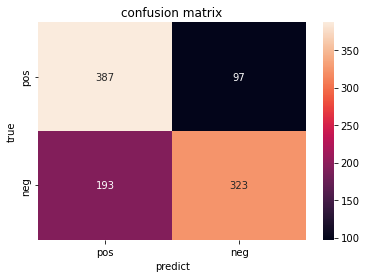

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
def plot_matrix(y_true, y_pred,title_name):
    cm = confusion_matrix(y_true, y_pred)#混淆矩阵
    #annot = True 格上显示数字 ，fmt：显示数字的格式控制
    ax = sn.heatmap(cm,annot=True,fmt='g',xticklabels=['pos','neg'],yticklabels=['pos','neg'])
    #xticklabels、yticklabels指定横纵轴标签
    ax.set_title(title_name) #标题
    ax.set_xlabel('predict') #x轴
    ax.set_ylabel('true') #y轴
    return ax
plot=plot_matrix(true,predic,'confusion matrix')
# plt.savefig('Confusion Matrix/CNN.png')
# 混淆矩阵

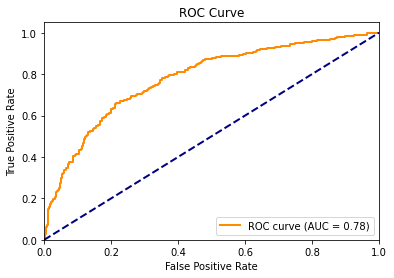

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 生成假标签和真标签
y_pred = outputs[:, 1].cpu().numpy()
y_true = true

# 计算FPR和TPR
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
np.savez('3',y1=y_pred,y2=y_true)
# 绘制ROC曲线
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()